# Paper analysis

The notebook proceeds as it follows:
1. Introduction
   1. Import libraries
   2. Import datasets
   3. Pre-processing data
   4. Define functions
2. Parameters fitting
   1. $p^*(H_i)$ function
   2. Subitem 2.2
3. Results analysis
   1. Territory map
   2. Measurement uncertainty and overall result
   3. Adeherence rate of the specific structure to each town
   4. Network on simulated data

## 1 - Introduction

### 1.1 - Import libraries

In [4]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, time
from dateutil.relativedelta import relativedelta
import random
from geneticalgorithm import geneticalgorithm as ga
import folium
import folium.plugins as plugins
import networkx as nx

plt.rcParams["font.family"] = "Times New Roman"

### 1.2 - import dataset

In [29]:
df = pd.read_excel("PS.xlsx") # data of the emergency care unit
df_comuni = pd.read_excel("towns.xlsx") # data of the towns
df_strutture = pd.read_excel("hospitals.xlsx") # data of the hospitals
df_dist = pd.read_excel("distances.xlsx") # distances between towns



### 1.3 - preprocessing data

In [30]:
# 1 - I make the hospital 'F' of the Varese bridge, which has two codes, all become '30003'

for index, row in df.iterrows():
    if row['cod_ist'] == 30003: 
        df.cod_ist.iloc[index] = 3090102

# 2 - Create a dictionary from df_dist because otherwise, it takes too long to make the analysis

dict_dist = {}
i = 0
for c1 in df_dist.cod_1.unique():
    i += 1

    for c2 in df_dist.cod_2.unique():
        chiave1 = (c1, c2)
        chiave2 = (c2, c1)
        if len(df_dist[(df_dist.cod_1 == c1) & (df_dist.cod_2 ==c2)]) > 0:
            d = df_dist[(df_dist.cod_1 == c1) & (df_dist.cod_2 ==c2)].d.iloc[0]
        else:
            d = df_dist[(df_dist.cod_1 == c2) & (df_dist.cod_2 ==c1)].d.iloc[0]
            

        dict_dist[chiave1] = d
        dict_dist[chiave2] = d

# 3 - Creation of a list with the unique hospital codes to avoid having to search for them every time.

hospitals = list(df.cod_ist.unique())

# 4 - Creation of a dictionary from df_strutture because otherwise, it takes too long

dict_strutture = dict(zip(df_strutture.codice_istituto, df_strutture.cod_comune))
dict_strutture_inv = {value: key for key, value in dict_strutture.items()}
dict_strutture

# 5 - Creation of two lists with the relative and absolute frequencies of arrivals at the hospitals

freq_ass_h, freq_rel_h = [], []
for h in hospitals: freq_ass_h.append(len(df[df.cod_ist == h]))
freq_rel_h = [f/sum(freq_ass_h) for f in freq_ass_h]

# 6 - Replacement of ascending numerical variables for the triage arrival codes

df = df.dropna(subset=["triage"]) # togli i vuoti
df = df[df.triage != "N"] # togli quelli arrivati morti
df.triage = df.triage.replace('B', 1) 
df.triage = df.triage.replace('V', 2)
df.triage = df.triage.replace('G', 3)
df.triage = df.triage.replace('R', 4)

# 7 - Creation of a dictionary with the number of beds for each hospital

dict_posti = dict(zip(df_strutture.codice_istituto, df_strutture.posti))
dict_posti

# 8 - Renaming the 'pop' column in the dataframe 'comuni' as 'population' to avoid conflicts with the 'pop' function in pandas.

df_comuni.rename(columns={'pop':'population'}, inplace=True)

/var/folders/rf/3t0lv19n2z7ghlp87kf59lkh0000gn/T/ipykernel_40430/706691065.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.cod_ist.iloc[index] = 3090102


### 1.4 - define functions

In [34]:
#scegli_ospedale
def choose_hospital(cod_res, t, list_par):

    p_star_hosp = []
    cod_res = int(cod_res)

    for hosp in hospitals:
        cod_res_hosp = int(dict_strutture[hosp]) # converti codice residenza in numero del comune 
        d = dict_dist[cod_res_hosp, cod_res] # distanza dall'ospedale
        list_var = d, t
        p_star_hosp.append(p_star(list_var, list_par, hospitals.index(hosp)))

    p_star_hosp = [p / sum(p_star_hosp) for p in p_star_hosp]
    hosp_selected = random.choices(hospitals, weights=p_star_hosp, k=1)[0]

    return hosp_selected

# simula_distribuzione
def simulate_distribution(num, list_par):
    
    df_test = df.sample(n=num, random_state=np.random.randint(0, 100000)) # seleziona un sottoinsieme e mischia il dataset
    destionation_sim, destionation_real, origin = [],[],[]

    for index, row in df_test.iterrows():
        cod_res, t = row['residenza'],row['triage']
        hosp_selected = choose_hospital(cod_res, t, list_par)
        destionation_sim.append(hosp_selected)
        destionation_real.append(row['cod_ist'])
        origin.append(cod_res)
    
    hosp_simulated = [destionation_sim.count(h) for h in hospitals]

    return hosp_simulated, destionation_sim, destionation_real, origin



def evaluate_experiment(hosp_sim,dest_real,dest_sim,freq_rel_h, origin):

    # I calculate the maximum deviation between the simulated frequencies and the actual frequencies.
    hosp_sim_rel = [h /sum(hosp_sim) for h in hosp_sim]
    error = []
    for _ in range(len(freq_rel_h)):
        error.append(abs(freq_rel_h[_] - hosp_sim_rel[_]))
    max_error = max(error)
    mean_error = np.mean(error)

    # If necessary (not while calibrating), I create a graph
    graphic = False
    if graphic:
        plt.rcParams["font.family"] = "Times New Roman"
        ci_range1 = range(len(hospitals))
        ci_range2 = [x + 0.21 for x in range(len(hospitals))]
        width = 0.18
        plt.bar(ci_range1, hosp_sim_rel, width = width, label = 'simulated', facecolor = 'salmon', alpha = 0.6, edgecolor='salmon')
        plt.bar(ci_range2, freq_rel_h, width = width, label = 'real data', facecolor = 'lightseagreen', alpha = 0.6, edgecolor='lightseagreen')
        plt.legend()
        plt.show()

    return max_error, mean_error

def experiment(alpha,beta,q,n):
    list_par = alpha,beta,q
    hosp_sim, dest_real, dest_sim, origin = simulate_distribution(n, list_par)
    return evaluate_experiment(hosp_sim,dest_real,dest_sim,freq_rel_h, origin)

## 2 - Parameters fitting

### 2.1 - $p^*(H_i)$ function

The function to fit is the following

$p^*(H_i) = \frac{q^{\alpha t}}{d^\beta}$

and the target parameters are $\alpha$ and $\beta$.

In [32]:
def p_star(list_var, list_par, i):  
    d,t = list_var  
    alpha,beta,q = list_par
    p_star_new = ( q[i] ** ( alpha * t ) ) / ( d ** beta )
    return p_star_new

### 2.2 - genetic algorithm calibration

The calibration is made in order to minimize the maximum error. Given that the error $e_i$ for each hospital $H_i$ is defined as

$e_i = \left|{f_i}^r - {f_i}^s\right|$

so the minimize target is $max(e_i)$.

 The best solution found:                                                                           
 [1.15023384 9.06816919]

 Objective function:
 0.019063032367972743


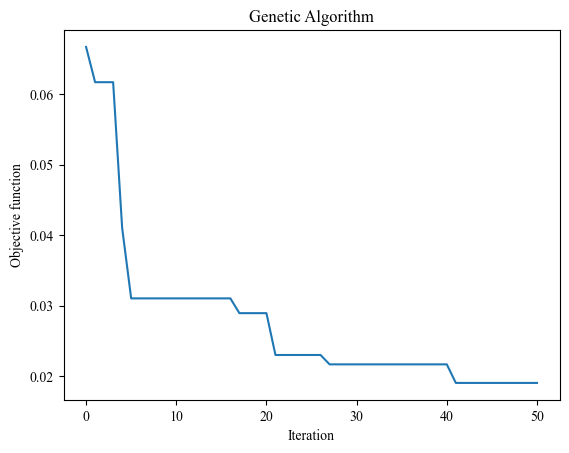

{'max_num_iteration': 50, 'population_size': 200, 'mutation_probability': 0.1, 'elit_ratio': 0.01, 'crossover_probability': 0.5, 'parents_portion': 0.3, 'crossover_type': 'uniform', 'max_iteration_without_improv': None}


In [54]:
def f(X):
    alpha, beta = X
    q = list(dict_posti.values())
    q = [x/sum(q) for x in q]
    max_error, mean_error = experiment(alpha,beta,q,200)
    return max_error

algorithm_param = {'max_num_iteration': 50,
                   'population_size':200,
                   'mutation_probability':0.1,
                   'elit_ratio': 0.01,
                   'crossover_probability': 0.5,
                   'parents_portion': 0.3,
                   'crossover_type':'uniform',
                   'max_iteration_without_improv':None
                  }

varbound=np.array([[0,10],[0,10]])
model=ga(function=f,dimension=2,variable_type='real',variable_boundaries=varbound, algorithm_parameters=algorithm_param, function_timeout = 10)
model.run()
print(algorithm_param)

### 2.3 - Results testing

Given the results of the genetic algorithm, the data are minimized with $\alpha = 0.21060097$ and $\beta = 3.69081222$. Here, it is possibile to test the result, obtaining respectively $max(e_i)$ and $E[e_i]$.

In [60]:
q = list(dict_posti.values())
q = [x/sum(q) for x in q]
alpha,beta = 0.21060097, 3.69081222
n_sim = 100

experiment(alpha,beta,q,n_sim) 

(0.14669505962521293, 0.050499716070414535)

Note that the results are different from the one in the paper because ar computed on a much smaller subsection of the dataset, which was randomly sampled.  

## 3 - Results analysis

### 3.1 - Territory map

In [25]:
map = folium.Map(location=[np.mean(df_comuni.lat), np.mean(df_comuni.long)], zoom_start=10.5, tiles='CartoDB Positron')

icon = folium.CustomIcon('hosp.png', icon_size=(40, 40))

city_hosp = list(df_strutture.cod_comune)
for _ in range(len(df_comuni)):

    if df_comuni.cod_comune.iloc[_] in city_hosp:
        color, icon = 'lightred', 'hospital'
    else:
        color, icon = 'blue', 'info-sign'


    folium.Marker(
        location=[df_comuni.lat[_], df_comuni.long[_]],
        popup=df_comuni.comune[_],
        icon=folium.Icon(icon=icon, color=color, icon_color="white", prefix="fa"),
    ).add_to(map)

map.save("mappa_paper.html")
map

### 3.2 - Measurement uncertainty and overall result

Since it is stochastic, here the simulation is repeated multiple times, to address the measured value and the uncertainty of measure (respectively, the mean and the standard deviation of the sample of the simulations).

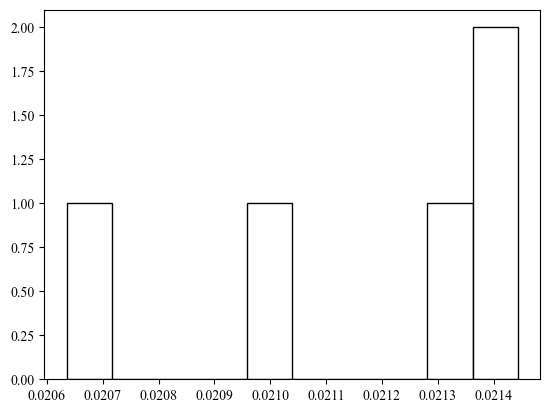

0.00030150857764583153
0.02115444771682246


In [34]:
alpha,beta,n_sim,q = 0.21060097, 3.69081222, 250089, [x/sum(list(dict_posti.values())) for x in list(dict_posti.values())]
iterations, res = 5, []
for _ in range(iterations): res.append(experiment(alpha,beta,q,n_sim)[0])

plt.hist(res, color = 'white', edgecolor = 'k')
plt.show()

print(np.std(res))
print(np.mean(res))

### 3.3 - City/hospital flow network

#### 3.3.1 - Data preparation for the movement

In [28]:
# Creation of a dataframe with movements from one city to another.

df_selected = df

res, cod_ist, com_ist, move, move_rel = [],[],[],[],[]
for ci in df.cod_ist.unique():
    for r in df.residenza.unique():
        move_all = len(df_selected[df.residenza == r])
        move_ci = len(df_selected[(df.residenza == r) & (df.cod_ist == ci)])

        move.append(move_ci)
        move_rel.append(move_ci / move_all)
        cod_ist.append(ci)
        com_ist.append(dict_strutture[ci])
        res.append(r)

df_move = pd.DataFrame({'cod_ist':cod_ist, 'com_ist':com_ist,'residenza':res, 'move':move, 'move_rel':move_rel})
df_move

# Creation of a dictionary that, for each city of residence, includes the city where there have been the most movements
res, com_ist = [],[]
for r in df_selected.residenza.unique():
    df_move_filt = df_move[df_move.residenza == r]

    ist = list(df_move_filt.com_ist.unique())
    mr = list(df_move_filt.move_rel.unique())

    res.append(r)
    com_ist.append(ist[np.argmax(mr)])

dict_maxmove = dict(zip(res, com_ist))

#### 3.3.2 - Network from real world data

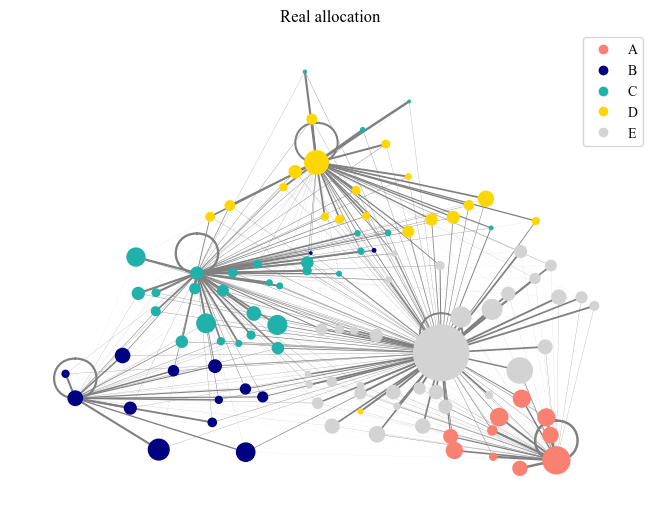

In [35]:
dict_cols = {12127: 'salmon', 12003: 'navy', 12051: 'lightseagreen', 12092: 'gold', 12133: 'lightgrey'}
dict_label = {12127: 'Tradate', 12003: 'Angera', 12051: 'Cittiglio', 12092: 'Luino', 12133: 'Varese'}

# Obtaining the unique values of the 'cod_com' column
strutture_cod_com, comuni_cod_com = df_strutture['cod_comune'].unique(), df_comuni['cod_comune'].unique()
scale_pop = 0.02

comuni_lat, comuni_long, comuni_pop, comuni_col = [],[],[],[]
for c in comuni_cod_com:
    comuni_lat.append(df_comuni[df_comuni['cod_comune'] == c]['lat'].iloc[0])
    comuni_long.append(df_comuni[df_comuni['cod_comune'] == c]['long'].iloc[0])
    comuni_pop.append(df_comuni[df_comuni['cod_comune'] == c]['population'].iloc[0] * scale_pop)
    comuni_col.append(dict_cols[dict_maxmove[str(c)]])

strutture_lat, strutture_long, strutture_pop, strutture_col = [],[],[],[]
for c in strutture_cod_com:
    strutture_lat.append(df_comuni[df_comuni['cod_comune'] == c]['lat'].iloc[0])
    strutture_long.append(df_comuni[df_comuni['cod_comune'] == c]['long'].iloc[0])
    strutture_pop.append(df_comuni[df_comuni['cod_comune'] == c]['population'].iloc[0] * scale_pop)
    strutture_col.append(dict_cols[dict_maxmove[str(c)]])

G = nx.Graph()

strutture_nodes = [(cod_com, {'pos': (lon, lat), 'pop': pop, 'col': col}) for cod_com, lat, lon, pop, col in zip(strutture_cod_com, strutture_lat, strutture_long, strutture_pop, strutture_col)]
comuni_nodes = [(cod_com, {'pos': (lon,lat), 'pop': pop, 'col': col}) for cod_com, lat, lon, pop, col in zip(comuni_cod_com, comuni_lat, comuni_long, comuni_pop, comuni_col)]

G.add_nodes_from(comuni_nodes, bipartite=1)
G.add_nodes_from(strutture_nodes, bipartite=0)

# Adding the edges that connect the nodes of the two parts
for cod_com in strutture_cod_com:
    for comune in comuni_cod_com:
        weight = df_move[(df_move.com_ist == cod_com) & (df_move.residenza == str(comune))].move_rel.iloc[0]
        G.add_edge(cod_com, comune,weight=weight)

edge_weights = nx.get_edge_attributes(G, 'weight')

# Draw the graph
pos = nx.get_node_attributes(G, 'pos')
sizes = nx.get_node_attributes(G, 'pop')
colors = nx.get_node_attributes(G, 'col')
labels = {node: node if G.nodes[node]['bipartite'] == 0 else '' for node in G.nodes}
nx.draw(G, pos, with_labels=False, 
    width=[2 * weight for weight in edge_weights.values()],
    node_size=list(sizes.values()), 
    node_color = list(colors.values()),
    edge_color='grey'
    )

dict_label_2 = {12127: 'A', 12003: 'B', 12051: 'C', 12092: 'D', 12133: 'E'}
colors = list(dict_cols.values())
legend_handles = []
legend_labels = []
for code, label in dict_label_2.items():
    color = dict_cols[code]
    legend_handles.append(plt.Line2D([], [], color=color, marker='o', linestyle='None'))
    legend_labels.append(label)

plt.legend(legend_handles, legend_labels)
plt.title('Real allocation')
plt.savefig('rete_real_all.png', dpi=300)
plt.show()

### 3.3.3 - Adeherence rate of the specific structure to each town

In [40]:
def esperimento_2(alpha,beta,q,n):

    list_par = alpha,beta,q
    hosp_sim, dest_real, dest_sim, origin = simulate_distribution(n, list_par)
    return origin, dest_sim, hosp_sim

mean:  0.01950168179387208
std:  0.027471409901766677
median:  0.00858760844081179


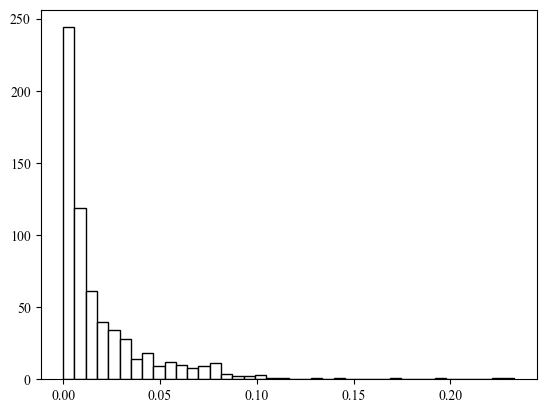

In [77]:
alpha,beta,n_sim, q = 0.21060097, 3.69081222, 25089, [x/sum(list(dict_posti.values())) for x in list(dict_posti.values())]

origin, dest_sim, hosp_sim = esperimento_2(alpha,beta,q,n_sim) 
dest_sim_cod = [dict_strutture[d] for d in dest_sim]
dest_sim_cod

res, hosp, miao, bau = [], [],[],[]
for r in list(set(origin)):
    tot_r = origin.count(r)
    for ci in list(set(dest_sim)):
        count = 0
        for _ in range(len(origin)):
            if origin[_] == r and dest_sim[_] == ci: count += 1
        res.append(r)
        hosp.append(ci)
        miao.append(count)
        bau.append(count / tot_r)

df_move_sim = pd.DataFrame({'res':res,'hosp':hosp,'move':miao,'move_rel':bau})
df_move_sim

error, distance = [], []
origin_unique = list(set(origin))
for r in origin_unique:
    for ci in list(set(dest_sim)):
        move_rel_sim = df_move_sim.loc[(df_move_sim['res'] == r) & (df_move_sim['hosp'] == ci),'move_rel'].values[0]
        move_rel_real = df_move.loc[(df_move['residenza'] == r) & (df_move['cod_ist'] == ci),'move_rel'].values[0] 
        error.append(abs(move_rel_sim - move_rel_real))

        #df_dist_filt = df_dist[(df_dist['cod_1'] == int(r)) & (df_dist['cod_2'] == int(dict_strutture[ci]))]
        #distance.append(df_dist_filt.d.iloc[0])

print('mean: ', np.mean(error))
print('std: ', np.std(error))
print('median: ', np.median(error))
plt.hist(error, bins = 40, color='white', edgecolor='black')
plt.savefig('hist_error_sim_real.png', dpi = 300)
plt.show()


In [64]:
df_dist

,comune_1,comune_2,cod_1,cod_2,lon1,lat1,lon2,lat2,d
0,Varese,Tradate,12133,12127,8.826384,45.817605,8.904642,45.713573,1308.1
1,Varese,Malnate,12133,12096,8.826384,45.817605,8.879766,45.800554,519.4
2,Varese,Luino,12133,12092,8.826384,45.817605,8.741682,46.002031,1816.2
3,Varese,Sesto Calende,12133,12120,8.826384,45.817605,8.634512,45.723966,1770.3
4,Varese,Induno Olona,12133,12083,8.826384,45.817605,8.839855,45.852311,455.5
...,...,...,...,...,...,...,...,...,...
11231,Marzio,Marzio,12099,12099,8.860324,45.938671,8.860324,45.938671,151.0
11232,Masciago Primo,Masciago Primo,12100,12100,8.780774,45.916933,8.780774,45.916933,152.0
11233,Tronzano Lago Maggiore,Tronzano Lago Maggiore,12129,12129,8.733796,46.089983,8.733796,46.089983,153.0
11234,Curiglia con Monteviasco,Curiglia con Monteviasco,12061,12061,8.804575,46.061172,8.804575,46.061172,154.0


### 3.3.3. - Network on simulated data

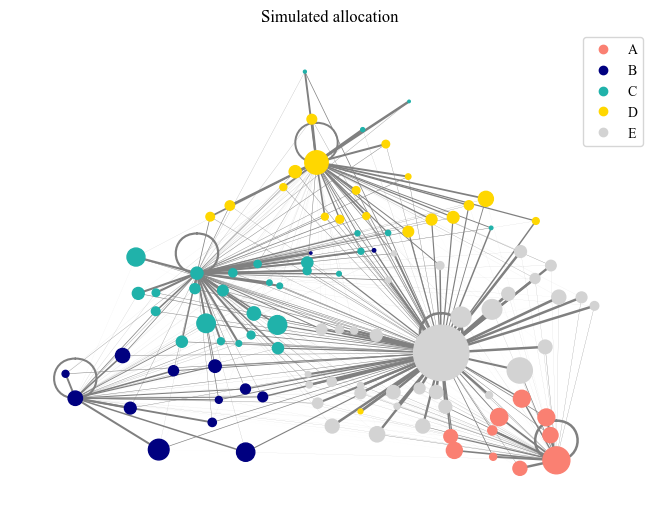

In [39]:
# Network from simulated data
df_move_sim['city_hosp'] = [dict_strutture[h] for h in df_move_sim.hosp]

dict_cols = {12127: 'salmon', 12003: 'navy', 12051: 'lightseagreen', 12092: 'gold', 12133: 'lightgrey'}
dict_label = {12127: 'Tradate', 12003: 'Angera', 12051: 'Cittiglio', 12092: 'Luino', 12133: 'Varese'}

# Obtain the unique values of the 'cod_com' column.
strutture_cod_com, comuni_cod_com = df_strutture['cod_comune'].unique(), df_comuni['cod_comune'].unique()
scale_pop = 0.02

comuni_lat, comuni_long, comuni_pop, comuni_col = [],[],[],[]
for c in comuni_cod_com:
    comuni_lat.append(df_comuni[df_comuni['cod_comune'] == c]['lat'].iloc[0])
    comuni_long.append(df_comuni[df_comuni['cod_comune'] == c]['long'].iloc[0])
    comuni_pop.append(df_comuni[df_comuni['cod_comune'] == c]['population'].iloc[0] * scale_pop)
    comuni_col.append(dict_cols[dict_maxmove[str(c)]])

strutture_lat, strutture_long, strutture_pop, strutture_col = [],[],[],[]
for c in strutture_cod_com:
    strutture_lat.append(df_comuni[df_comuni['cod_comune'] == c]['lat'].iloc[0])
    strutture_long.append(df_comuni[df_comuni['cod_comune'] == c]['long'].iloc[0])
    strutture_pop.append(df_comuni[df_comuni['cod_comune'] == c]['population'].iloc[0] * scale_pop)
    strutture_col.append(dict_cols[dict_maxmove[str(c)]])

G = nx.Graph()

strutture_nodes = [(cod_com, {'pos': (lon, lat), 'pop': pop, 'col': col}) for cod_com, lat, lon, pop, col in zip(strutture_cod_com, strutture_lat, strutture_long, strutture_pop, strutture_col)]
comuni_nodes = [(cod_com, {'pos': (lon,lat), 'pop': pop, 'col': col}) for cod_com, lat, lon, pop, col in zip(comuni_cod_com, comuni_lat, comuni_long, comuni_pop, comuni_col)]

G.add_nodes_from(comuni_nodes, bipartite=1)
G.add_nodes_from(strutture_nodes, bipartite=0)

# Adding the edges that connect the nodes of the two parts
for cod_com in strutture_cod_com:
    for comune in comuni_cod_com:
        df_move_sim_filt = df_move_sim[(df_move_sim.city_hosp == cod_com) & (df_move_sim.res == str(comune))]
        weight = sum(df_move_sim_filt.move_rel)
        G.add_edge(cod_com, comune, 
            weight=weight
        )

edge_weights = nx.get_edge_attributes(G, 'weight')
# Draw the graph
pos = nx.get_node_attributes(G, 'pos')
sizes = nx.get_node_attributes(G, 'pop')
colors = nx.get_node_attributes(G, 'col')
labels = {node: node if G.nodes[node]['bipartite'] == 0 else '' for node in G.nodes}
nx.draw(G, pos, with_labels=False, 
    width=[2 * weight for weight in edge_weights.values()],
    node_size=list(sizes.values()), 
    node_color = list(colors.values()),
    edge_color='grey'
    )

dict_label_2 = {12127: 'A', 12003: 'B', 12051: 'C', 12092: 'D', 12133: 'E'}
colors = list(dict_cols.values())
legend_handles = []
legend_labels = []
for code, label in dict_label_2.items():
    color = dict_cols[code]
    legend_handles.append(plt.Line2D([], [], color=color, marker='o', linestyle='None'))
    legend_labels.append(label)

# Show the graph
plt.title('Simulated allocation')
plt.legend(legend_handles, legend_labels)
plt.savefig('rete_sim_all.png', dpi=300)
plt.show()

### 3.3.5 - Comparison of main hospital for each city for real data and simulated data

In [62]:
city, pop, dist, max_city_hosp_real, max_city_hosp_sim = [],[],[],[],[]
for r in df_move.residenza.unique():
    city.append(r)
    pop.append(int(df_comuni[df_comuni.cod_comune == int(r)].population))

    df_real = df_move[df_move.residenza == r]
    df_sim = df_move_sim[df_move_sim.res == r]

    pct_real, cod_ist_real = list(df_real.move_rel), list(df_real.com_ist)
    pct_sim, cod_ist_sim = list(df_sim.move_rel), list(df_sim.city_hosp)

    max_city_hosp_real.append(cod_ist_real[np.argmax(pct_real)])
    max_city_hosp_sim.append(cod_ist_sim[np.argmax(pct_sim)])

df_hosp_max = pd.DataFrame({'city': city, 'pop': pop, 'max_city_hosp_real': max_city_hosp_real, 'max_city_hosp_sim': max_city_hosp_sim})

df_hosp_max_filt = df_hosp_max[df_hosp_max.max_city_hosp_real != df_hosp_max.max_city_hosp_sim]
print(len(df_hosp_max_filt))

df_hosp_max

0


,city,pop,max_city_hosp_real,max_city_hosp_sim
0,12137,7289,12127,12127
1,12136,5980,12127,12127
2,12127,18797,12127,12127
3,12134,7328,12127,12127
4,12046,7635,12127,12127
...,...,...,...,...
101,12066,137,12051,12051
102,12001,416,12092,12092
103,12129,219,12092,12092
104,12099,311,12092,12092
